<B>What Should we Do in this Data ? </B>
<Br>

1- Perform Analysis of the data related to this competition <Br>
2- Apply simple Forecasting models and use the same evaluation from the competition.<Br>
3- Apply ETS models (not all models explained, the one that you can see is suitable)<Br>
4- Apply the Arima model<Br>
5- Apply Prophet<Br>
6- Apply any machine learning of your choice<Br>
7- Choose the best among them and perform future forecasting on the test set and submit on Kaggle and add the score in your notebook sent to me,

<B>Dataset Description</B><br>
Historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

<B>Files</B><br>
train.csv - historical data including Sales<br>
test.csv - historical data excluding Sales<br>
store.csv - supplemental information about the stores
Data fields


<b>Columns</b> <br>
1 - **Id** - an Id that represents a (Store, Date) duple within the test set<br>
2 - **Store** - a unique Id for each store<br>
3 - **Sales** - the turnover for any given day (this is what you are predicting)<br>
4 - **Customers** - the number of customers on a given day<br>
5 - **Open** - an indicator for whether the store was open: 0 = closed, 1 = open<br>
6 - **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools 1 are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
7 - **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools<br>
8 - **StoreType** - differentiates between 4 different store models: a, b, c, d<br>
9 - **Assortment** - describes an assortment level: a = basic, b = extra, c = extended<br>
10 - **CompetitionDistance** - distance in meters to the nearest competitor store<br>
11 - **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened<br>
12 - **Promo** - indicates whether a store is running a promo on that day<br>
13 - **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
14 - **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2<br>
15 - **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

<h2><B>Import Libraries</B><h2>

In [84]:
# %pip install matplotlib seaborn statmodels adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose , STL
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<h2><B>Read Data</B><h2>

In [85]:
train = pd.read_csv("Data/train.csv",parse_dates=['Date'],low_memory=False)   
store_df = pd.read_csv("Data/store.csv")    
test = pd.read_csv("Data/test.csv",parse_dates=['Date'],low_memory=False)   

<B>We need to merge the Stores Data to the Train Dataset to work on it </B>

<B>✅ . Why merge them?</B>
🔧 So that your training data has all the features:You want to predict Sales, so the model should understand things like:<Br>

1 - Does a StoreType a generally sell more than StoreType d? <Br>
2 - Do stores with shorter CompetitionDistance perform worse? <Br>
3 - Do Promo2 stores show more stable growth? <Br>

These insights only become learnable by your model if you merge that info into train.csv.

In [86]:
df_train = pd.merge(train , store_df, how='left', on=['Store'])
print(df_train.shape)
print("*"*50)
print(df_train.columns)
print("*"*50)
df_train.head(5)

(1017209, 18)
**************************************************
Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
**************************************************


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


<h2><b>EDA Stage</b><h2>

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [88]:
df_train.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870


In [89]:
df_train.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

In [90]:
df_train.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

<B>So we have a null values in some columns let's see how can we deal with each one</B>

In [91]:
# 1 - CompetitionDistance  >>>> Reason for missing: Some stores might not have nearby competitors recorded.
# i will Replace with the maximum value + 1, or the median, so that it's distinguishable or neutral.
df_train['CompetitionDistance'] = df_train['CompetitionDistance'].fillna(df_train['CompetitionDistance'].max()+1)

# 2.CompetitionOpenSinceMonth & CompetitionOpenSinceYear : Missing probably means no competition, so: Fill with 0  just assume no competition effect
df_train['CompetitionOpenSinceMonth'] = df_train['CompetitionOpenSinceMonth'].fillna(0)
df_train['CompetitionOpenSinceYear'] = df_train['CompetitionOpenSinceYear'].fillna(0)

<B>Let's see some details about the Sales column and the distribution</B>

In [92]:
df_train['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

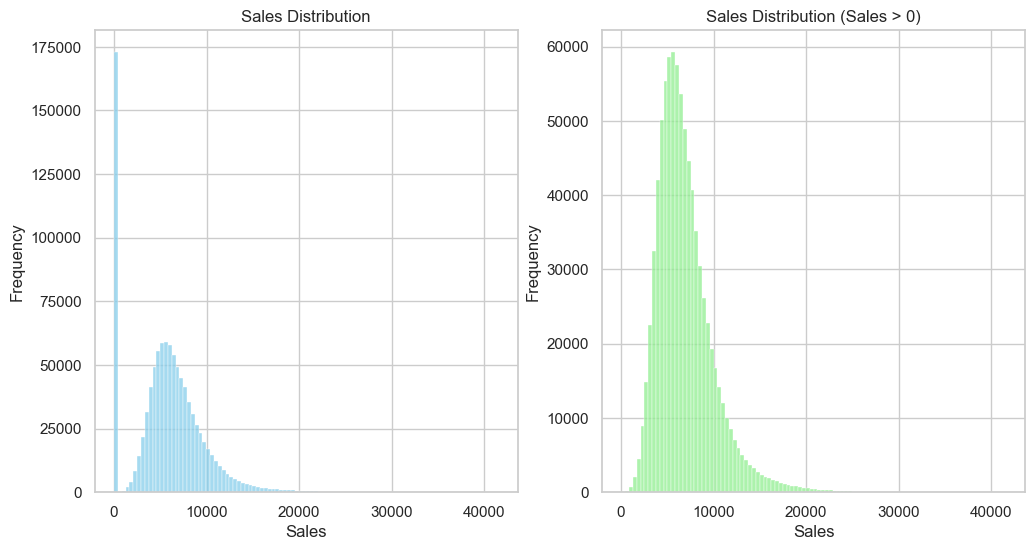

In [93]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.histplot(data=df_train, x='Sales', bins=100 , color='skyblue')  
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")

# plot 2 : sales > 0 

plt.subplot(1,2,2)
sns.histplot(data=df_train[df_train['Sales']>0], x='Sales', bins=100 , color='lightgreen')  
plt.title("Sales Distribution (Sales > 0)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

<B>Interpretation of the last 2 Plots<B>

🔹 Left Plot: All Sales Values (Including 0)<Br>
There's a sharp spike at zero, meaning many days had no sales.<Br>
This likely corresponds to days when stores were closed <br>
After the zero peak, the distribution gradually tapers off, with some very high values (right-skewed).<Br>


🔹 Right Plot: Sales > 0 <br>
When filtering out the zero values, the distribution appears smoother and more like a right-skewed normal distribution.<Br>
The majority of sales lie between 2,000 to 10,000, with fewer days having very high sales.<Br>
These high-sales days could be influenced by seasonality, holidays, or promotions — which are important in a time series context.


------------------------------------------------------------------------------------------------------------------------------------------------------------

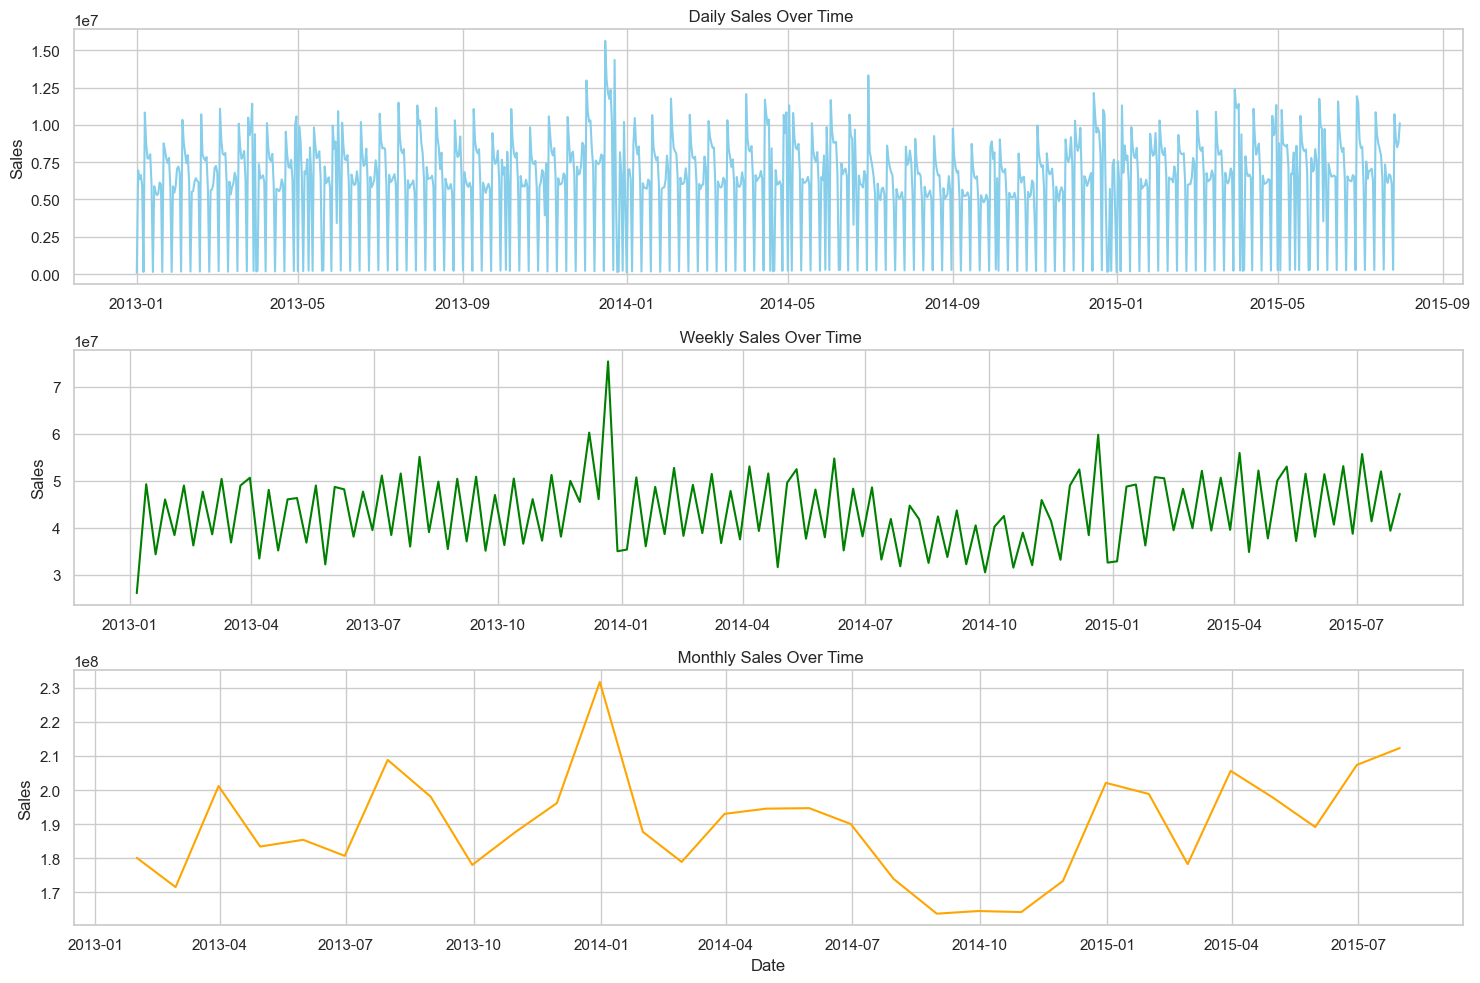

In [94]:
# Daily Sales (just group by date)
daily_sales = df_train.groupby('Date')['Sales'].sum().reset_index().set_index('Date')   
# Weekly Sales (resample by week)
weekly_sales = df_train.set_index('Date')['Sales'].resample('W').sum().reset_index()
# Monthly Sales (resample by month)
monthly_sales = df_train.set_index('Date')['Sales'].resample('ME').sum().reset_index()

plt.figure(figsize=(15, 10))

# Daily
plt.subplot(3, 1, 1)
sns.lineplot(data=daily_sales, x='Date', y='Sales', color='skyblue')
plt.title(' Daily Sales Over Time')
plt.xlabel('')
plt.ylabel('Sales')
plt.grid(True)

# Weekly
plt.subplot(3, 1, 2)
sns.lineplot(data=weekly_sales, x='Date', y='Sales', color='green')
plt.title(' Weekly Sales Over Time')
plt.xlabel('')
plt.ylabel('Sales')
plt.grid(True)

# Monthly
plt.subplot(3, 1, 3)
sns.lineplot(data=monthly_sales, x='Date', y='Sales', color='orange')
plt.title(' Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

plt.tight_layout()
plt.show()

<b>
"The daily sales data shows strong short-term volatility and clear weekly seasonality. The regular peaks suggest consistent high-sales days, likely weekends or promotional events. Notably, there's a sharp spike around December 2013, possibly due to holiday season shopping, and another spike around January 2015."<br>

Weekly sales smooth out the daily noise, revealing periodic seasonality and clearer medium-term fluctuations. Spikes observed around the end of 2013 and start of 2015 stand out more clearly, likely due to holiday-driven promotions. A downward trend can be noticed during mid-2014, potentially linked to store closures or reduced activity<Br>

The monthly sales trend highlights clear long-term seasonality and cyclical behavior. There’s a strong peak in December 2013, indicating a holiday season effect. After a dip in mid-2014, sales recovered and showed a growing trend into mid-2015. This plot is valuable for high-level strategic planning, such as budget forecasts or campaign timing.<BR>

___________________________________________________________________________________________________________________________________________________________________________
</b>

<b>Making a bar plot to know which dayOftheWeek and which month has the most sales</b>

In [95]:
# Ensure date index
daily_sales['Year'] = daily_sales.index.year
daily_sales['Month'] = daily_sales.index.month
daily_sales['Day'] = daily_sales.index.day
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['WeekOfYear'] = daily_sales.index.isocalendar().week

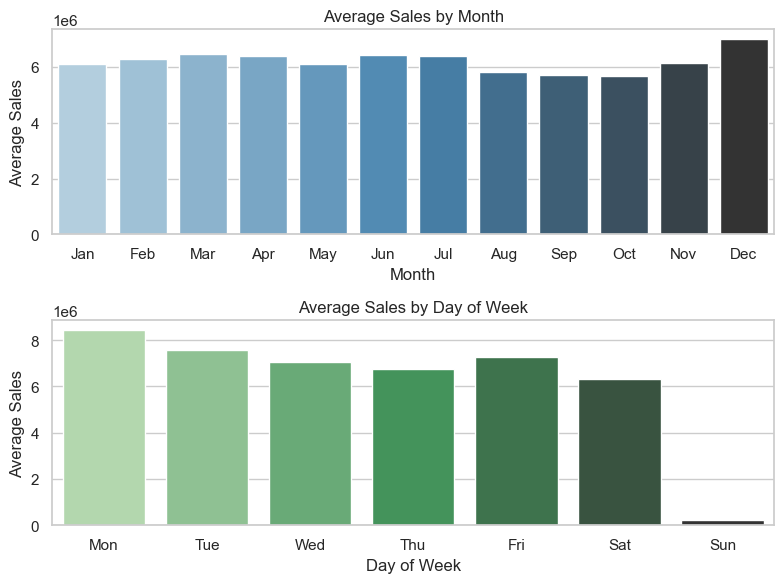

In [96]:
# Set seaborn theme
sns.set_theme(style="whitegrid")

# Prepare data
monthly_sales = daily_sales.groupby('Month')['Sales'].mean().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(int)

dow_sales = daily_sales.groupby('DayOfWeek')['Sales'].mean().reset_index()
dow_sales['DayOfWeek'] = dow_sales['DayOfWeek'].astype(int)

# Day names and month names for labeling
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create the figure
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Monthly bar plot
sns.barplot(x='Month', y='Sales', data=monthly_sales, ax=ax[0], palette="Blues_d",hue='Month',legend=False) 
ax[0].set_title('Average Sales by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average Sales')
ax[0].set_xticks(range(12))
ax[0].set_xticklabels(month_names)

# Weekly bar plot
sns.barplot(x='DayOfWeek', y='Sales', data=dow_sales, ax=ax[1], palette="Greens_d",hue='DayOfWeek',legend=False)
ax[1].set_title('Average Sales by Day of Week')
ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Average Sales')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(day_names)

plt.tight_layout()
plt.show()

<B>Making Multiple Box Plots to show different categorical features and it's influence the distribution of Sales. <B>

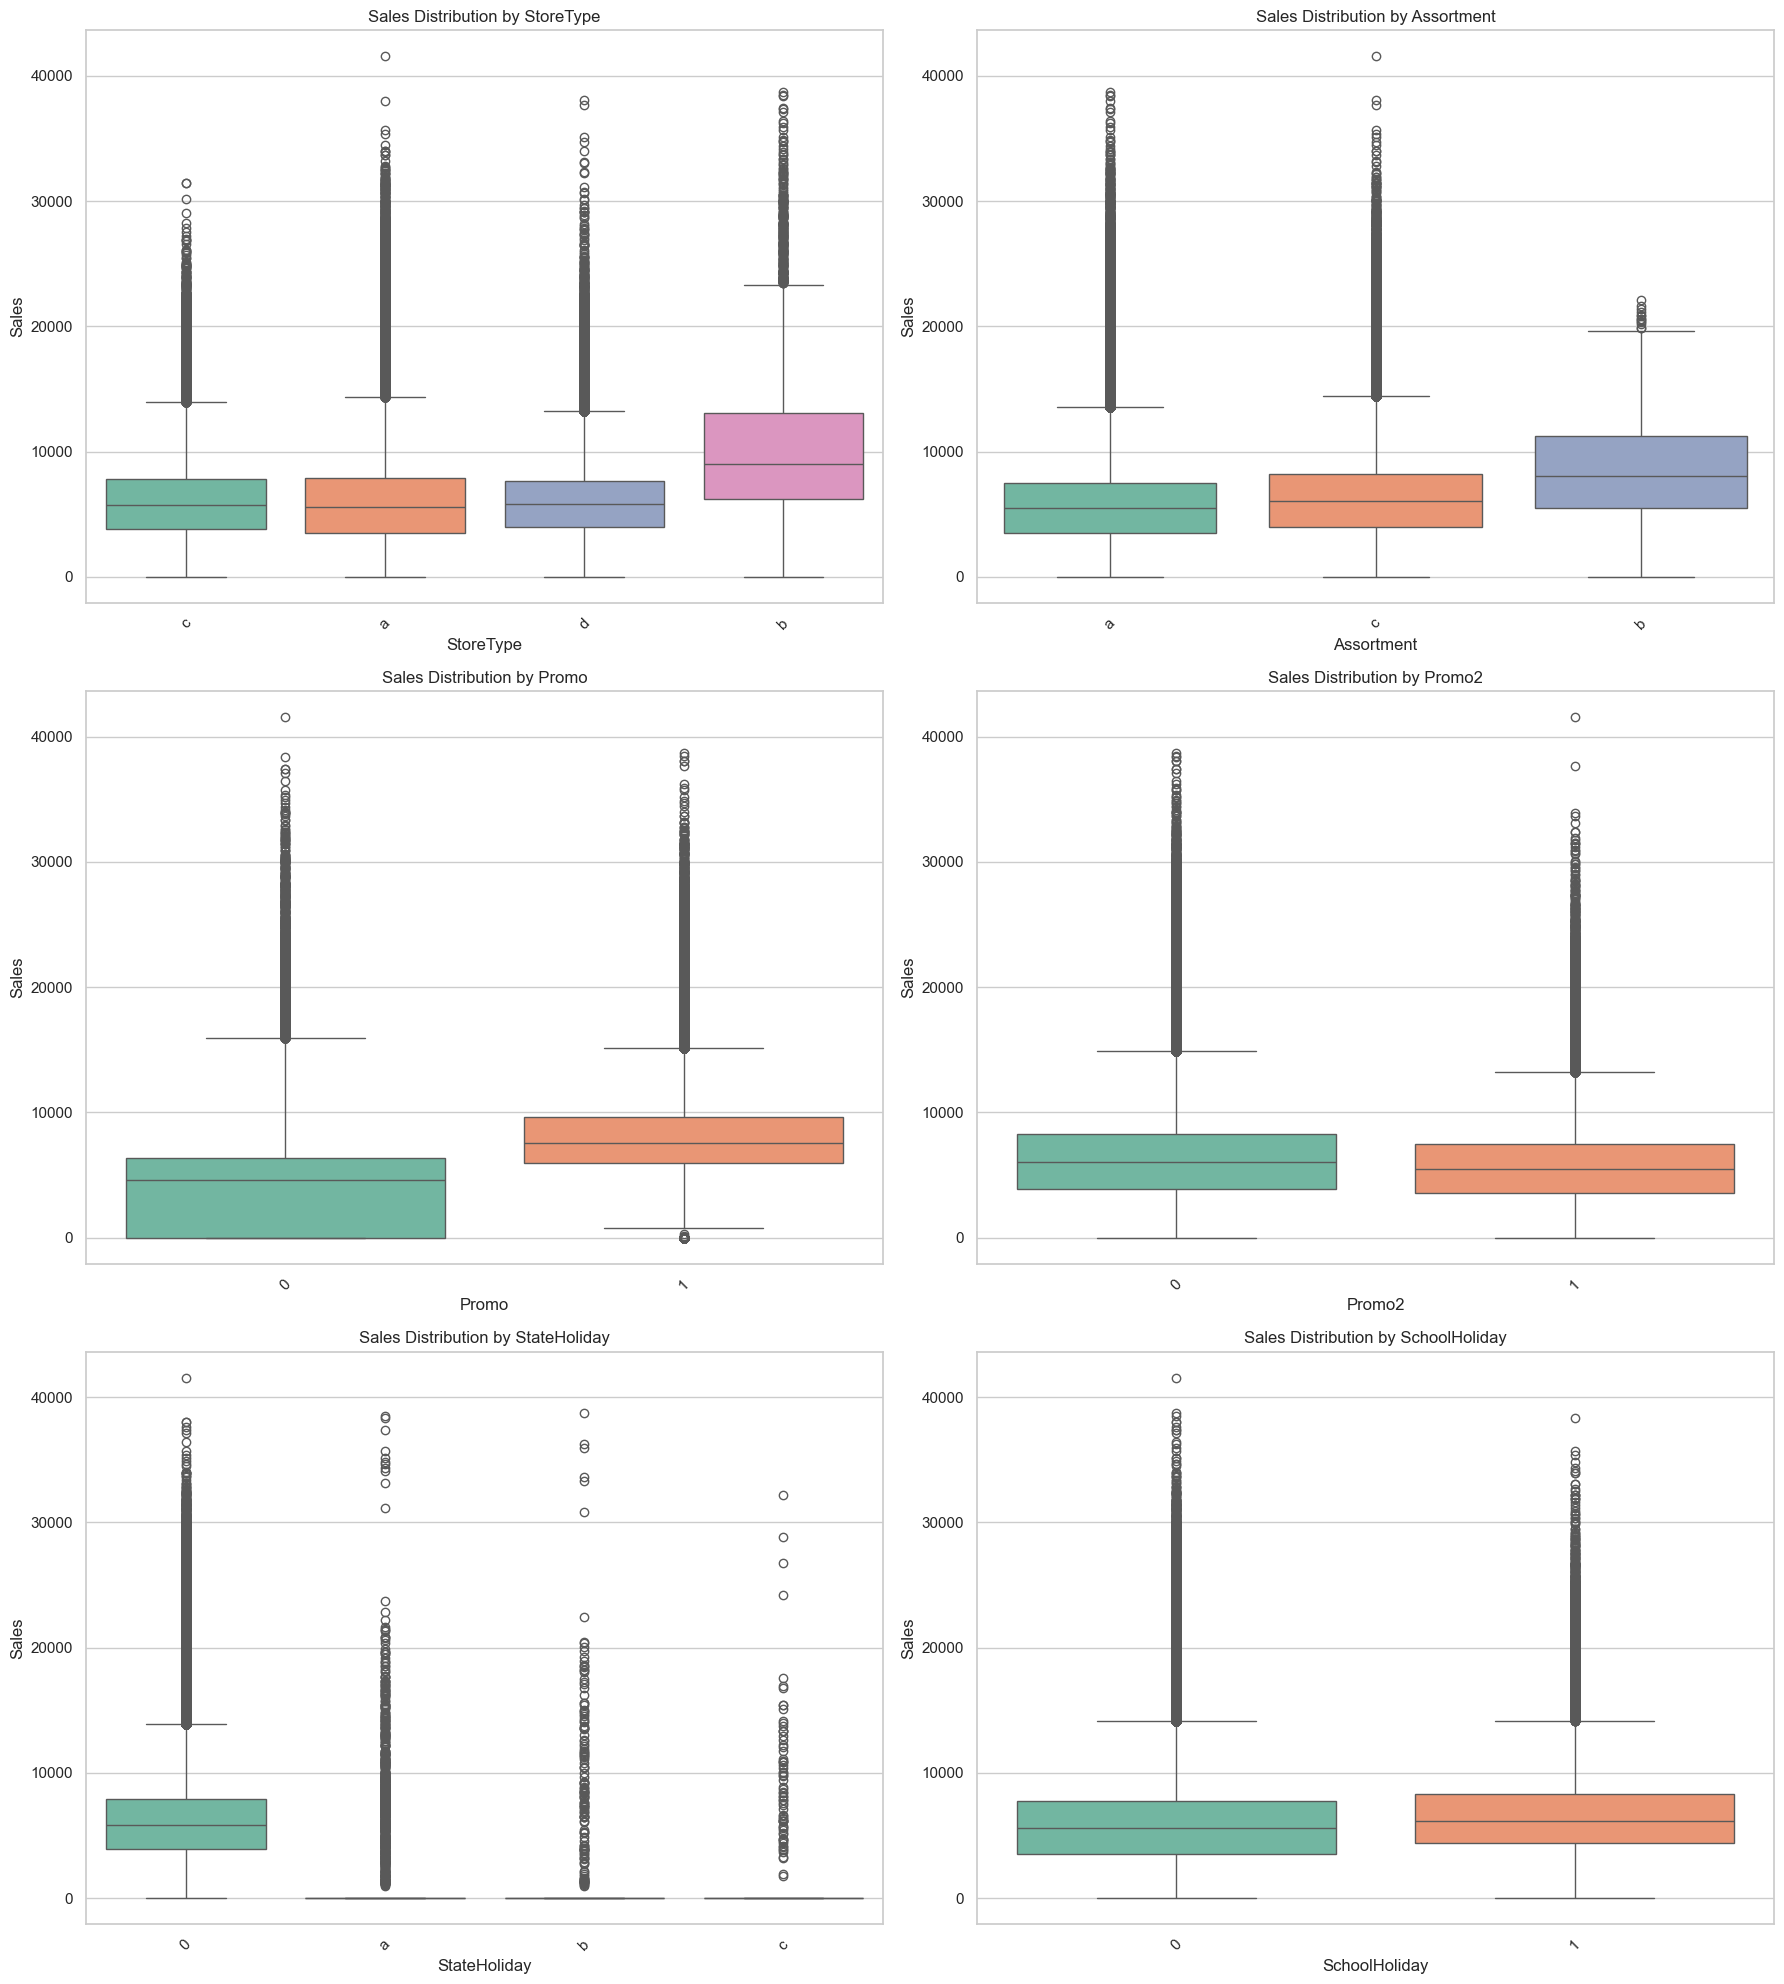

In [97]:
features = ['StoreType', 'Assortment','Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday']


plt.figure(figsize=(18, 20))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=feature, y='Sales', data=df_train, palette='Set2',hue=feature,legend=False)
    plt.title(f'Sales Distribution by {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


<h2><b>Let's go to Time series Decomposition Zone</b></h2>

Let's decompose our time series to understand the trend, seasonality, and residual components.

**Why do Time Series Decomposition?**<Br>
To understand the structure of our data before modeling.  <Br>
To detect seasonal patterns and trends that impact sales.<Br>
To help choosing the right model (e.g., ARIMA, SARIMA, Prophet).<Br>
To possibly remove the trend or seasonality (detrending, deseasonalizing) before modeling.


**In Our Case**<BR>
in decomposition,i will start with aggregated sales (all stores) to spot general trends and seasonality.<br>
Then optionally do per-store decomposition for deeper insights or custom forecasting models. (maybe)


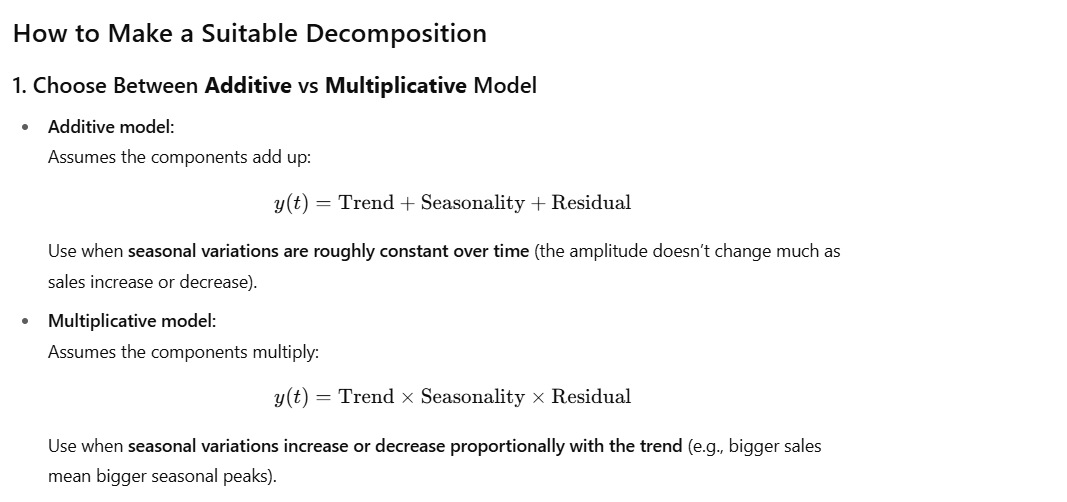

In [98]:
# 1 - make the data the index
df_train.set_index('Date', inplace=True)

# 2 - Aggregate the daily Sales Across all stores
daily_sales = df_train.groupby('Date')['Sales'].sum()

C:\Users\aliay\AppData\Local\Temp\ipykernel_19772\741145807.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  decomp_df['Residual'].fillna(0, inplace=True)


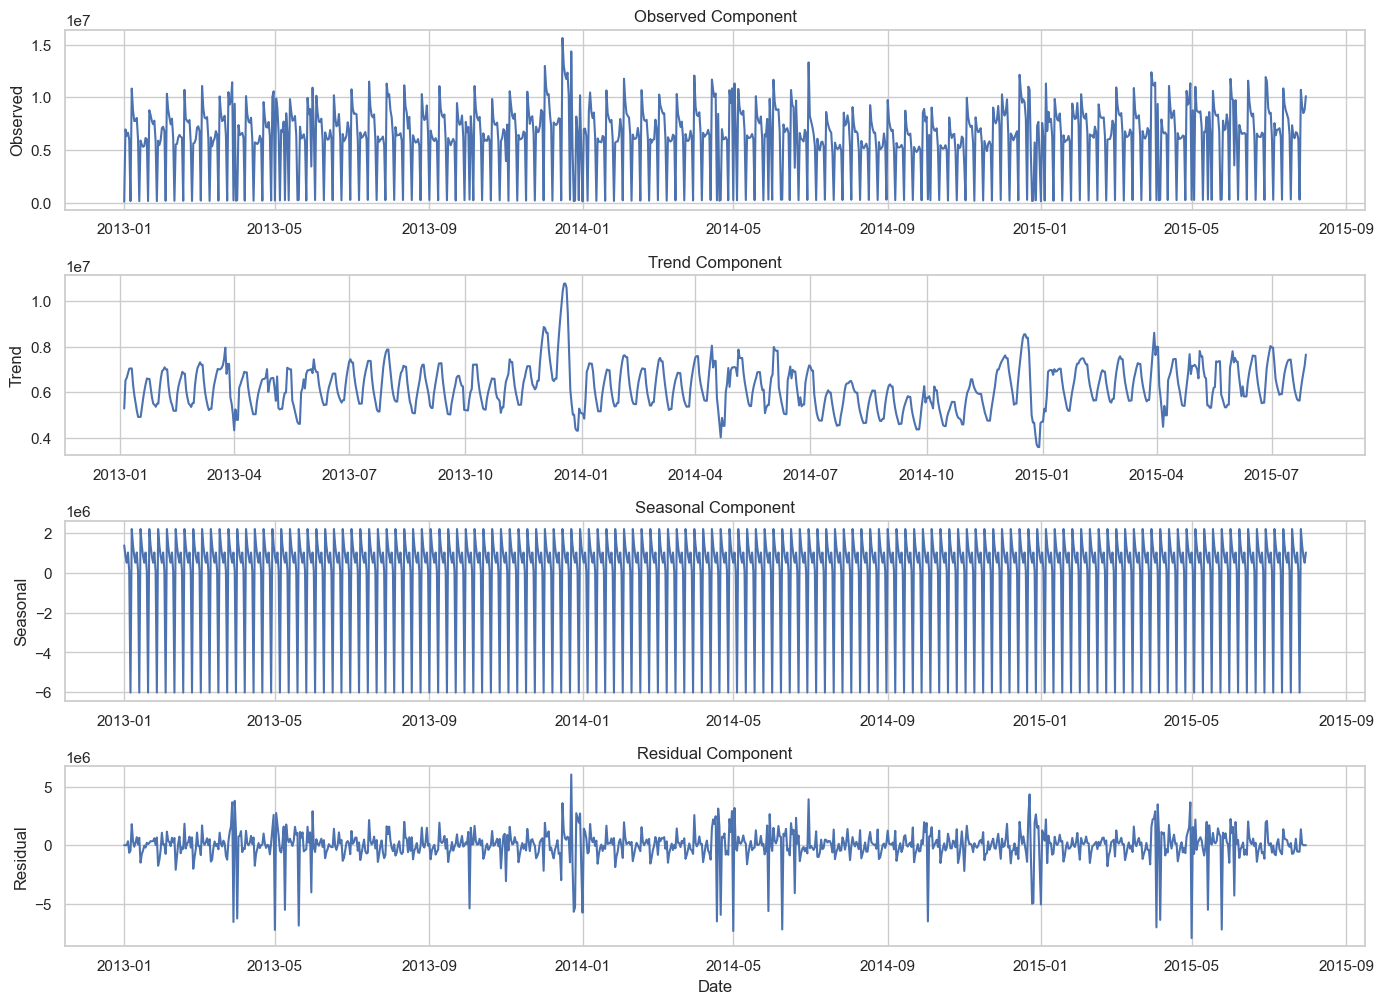

In [99]:
result = seasonal_decompose(daily_sales, model='additive', period=7) 

# Assuming daily_sales is a pandas Series with a datetime index
decomp_df = pd.DataFrame({
    'Observed': result.observed,
    'Trend': result.trend,
    'Seasonal': result.seasonal,
    'Residual': result.resid
})

decomp_df['Residual'].fillna(0, inplace=True)

plt.figure(figsize=(14, 10))

components = ['Observed', 'Trend', 'Seasonal', 'Residual']

for i, comp in enumerate(components, 1):
    plt.subplot(4, 1, i)
    sns.lineplot(data=decomp_df, x=decomp_df.index, y=comp)
    plt.title(f'{comp} Component')
    plt.xlabel('')
    plt.tight_layout()

plt.xlabel('Date')
plt.show()

<B>Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) helps understand the dependence of your time series with its past values — essential for model identification (like ARIMA).
</B>

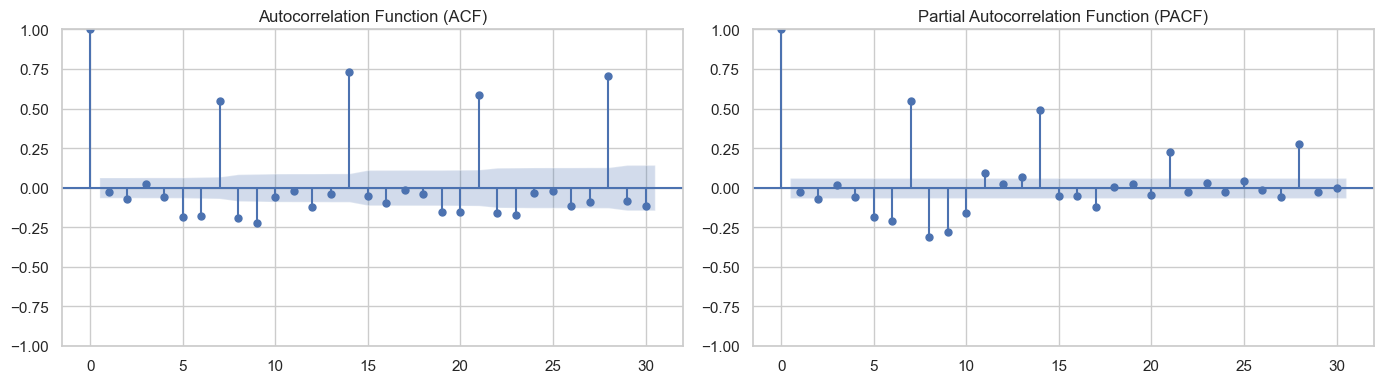

In [105]:
plt.figure(figsize=(14,4))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(daily_sales.dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(daily_sales.dropna(), lags=30, ax=plt.gca(), method='ywm')  # 'ywm' is a stable method
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

<B>Try making Decomposition Using STL </B>

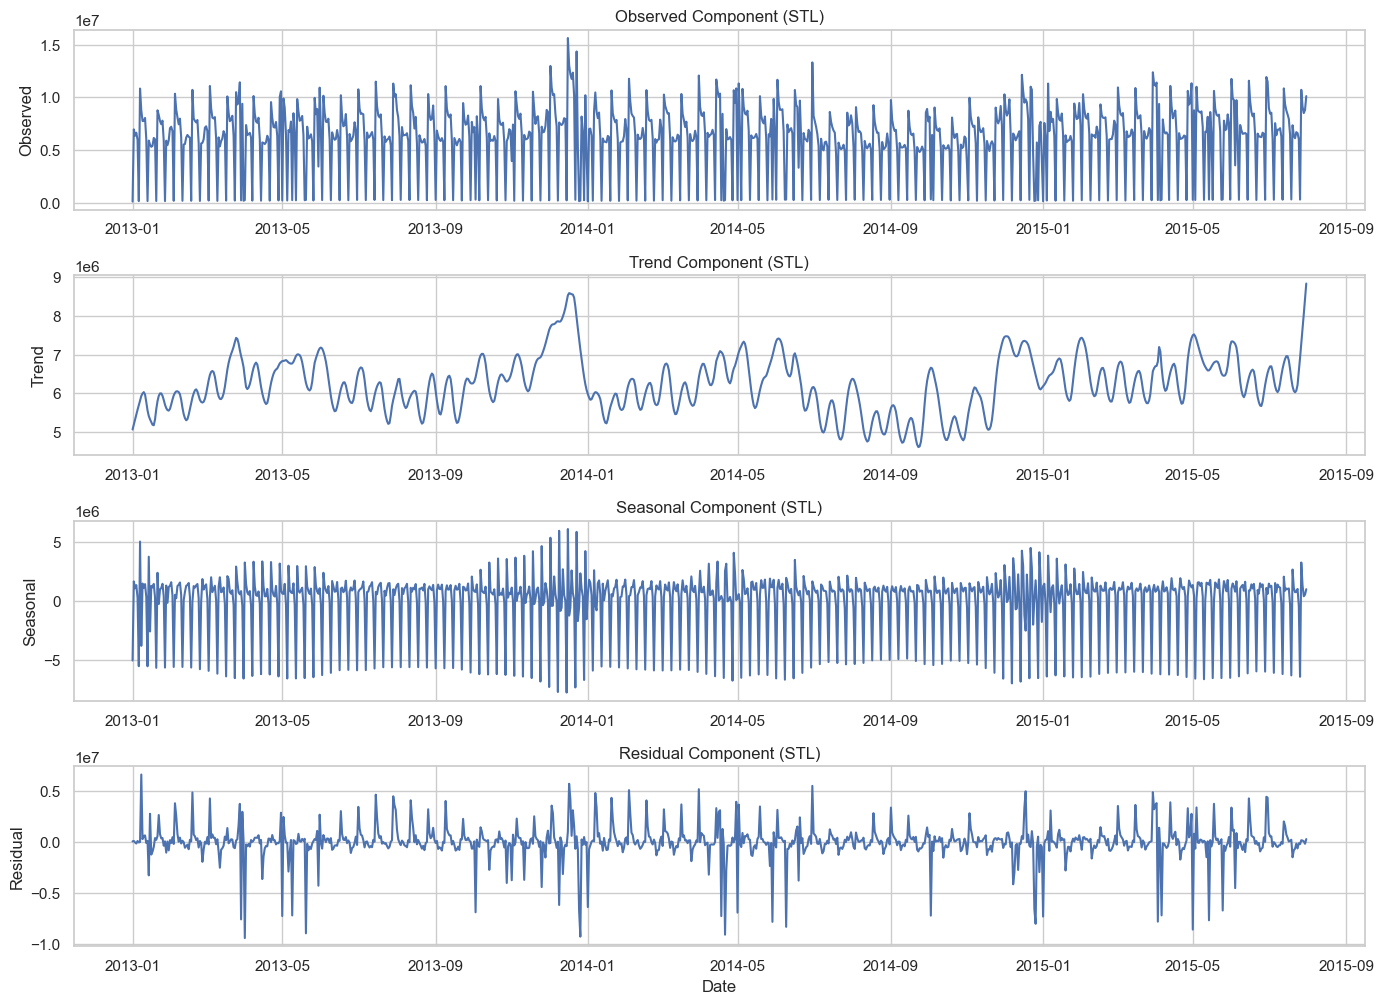

In [101]:
# Assuming daily_sales is a pandas Series indexed by date
stl = STL(daily_sales, period=7, robust=True)
result = stl.fit()

# Create a DataFrame with STL components
stl_df = pd.DataFrame({
    'Observed': result.observed,
    'Trend': result.trend,
    'Seasonal': result.seasonal,
    'Residual': result.resid
})

plt.figure(figsize=(14, 10))
components = ['Observed', 'Trend', 'Seasonal', 'Residual']

for i, comp in enumerate(components, 1):
    plt.subplot(4, 1, i)
    sns.lineplot(data=stl_df, x=stl_df.index, y=comp)
    plt.title(f'{comp} Component (STL)')
    plt.xlabel('')
    plt.tight_layout()

plt.xlabel('Date')
plt.show()

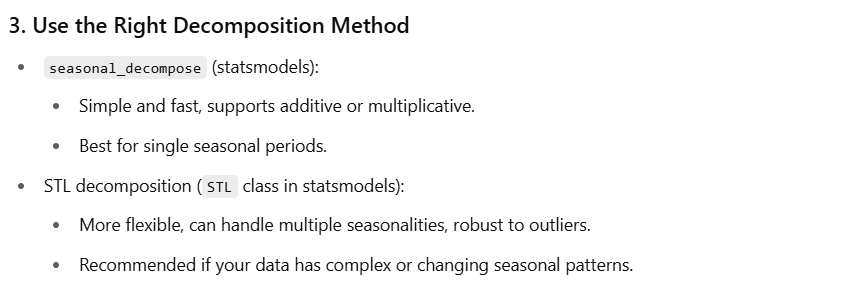

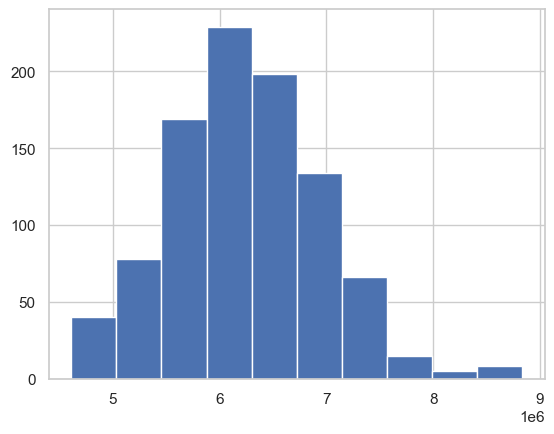

In [102]:
# indication for seasonality but we Should look for the different tests 
pd.Series(result.trend).hist();

<B>Apply Augmented Dickey-Fuller (ADF) test </B>

is a common statistical test used to check whether a time series is stationary or not (i.e., whether it has a constant mean and variance over time).

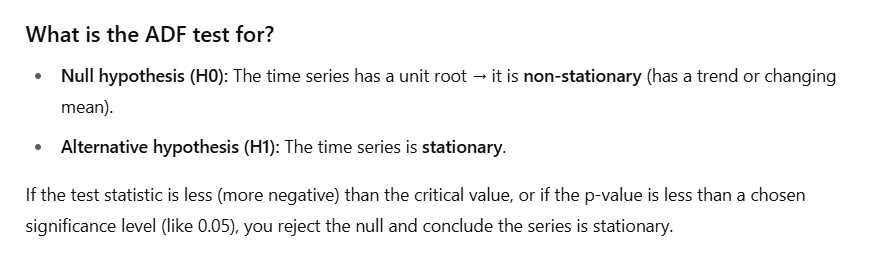

In [103]:
trend = result.trend.dropna()  # drop NaNs because ADF requires complete data

adf_result = adfuller(trend)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if adf_result[1] < 0.05:
    print("Reject H0 — The trend component is stationary.")
else:
    print("Fail to reject H0 — The trend component is non-stationary.")


ADF Statistic: -3.0937074674820653
p-value: 0.027022382327009986
Critical Values:
   1%: -3.437439232284603
   5%: -2.8646696476686477
   10%: -2.5684364181154127
Reject H0 — The trend component is stationary.


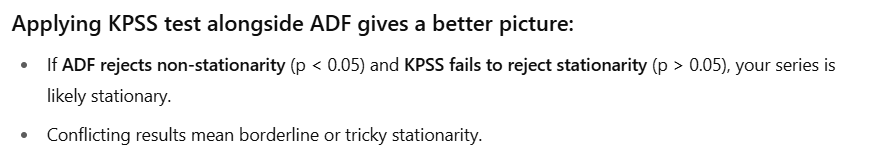

In [104]:
kpss_result = kpss(trend, regression='c')       # 'c' for constant (level stationarity)

print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'   {key}: {value}')

# Interpretation
if kpss_result[1] > 0.05:
    print("Fail to reject H0 — The trend component is stationary.")
else:
    print("Reject H0 — The trend component is non-stationary.")

KPSS Statistic: 0.19548219375681683
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject H0 — The trend component is stationary.


C:\Users\aliay\AppData\Local\Temp\ipykernel_19772\3903466246.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(trend, regression='c')       # 'c' for constant (level stationarity)


<B>So it's Completely stationary</B>


**What this means practically:**<br>

The trend doesn’t have a unit root — it doesn’t wander randomly or have persistent drift.<br>
It has a stable mean and variance over time (no strong trending or explosive behavior).<br>
we can confidently apply models that assume stationarity on this component, such as ARIMA without differencing.

------------------------------------------------------------------------------------------------------------------------------------------------------------------